# Leaky Mode Scaling

Given an input function $f_0$ to a waveguide, how can we scale the leaky modes easily to give the correct asymptotic behavior?

Since we now have the correct scaling from the contour integral, we know the residues.  Can we back out how to do the residues from this?

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from slab import SlabExact
from scipy.optimize import newton
from scipy.integrate import quad
plt.style.use('dark_background')
%matplotlib widget

In [2]:
loss_min_wl = 5.828070175438596e-06

A = SlabExact(scale=1e-5, Ts=[6.5, 1, 8, 1, 6.5],
              ns=[1, 1.44, 1, 1.44, 1], xrefs=[100, 40, 300, 40, 100],
              symmetric=True, wl=loss_min_wl)

In [3]:
b = 1.25
a = 1/ b**2
def quadratic_piecewise(x):
    conds = [(x<-b), ((-b<=x)*(x<=b)), (x>b)]
    funcs = [0, lambda x: 1 - a * x**2, 0]
    return np.piecewise(x, conds, funcs)
    
def modified_dist(x):
    return (x-1/4) * np.exp(-(x-1/2)**2)  

def odd_modified_dist(x):
    return x * np.exp(-x**2)
    
def normal_dist(x):
    return np.exp(-x**2)

f0 = quadratic_piecewise

/home/pv/local/slab/slab.py:1729: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=legend_fontsize)


(<Figure size 1200x500 with 1 Axes>, <Axes: >)

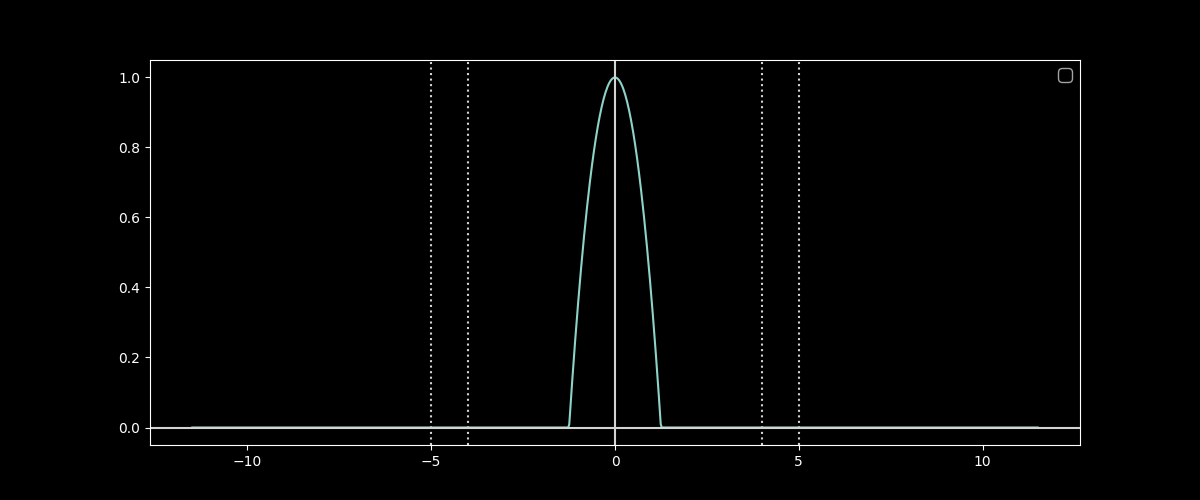

In [4]:
A.plot_field_1d(f0)

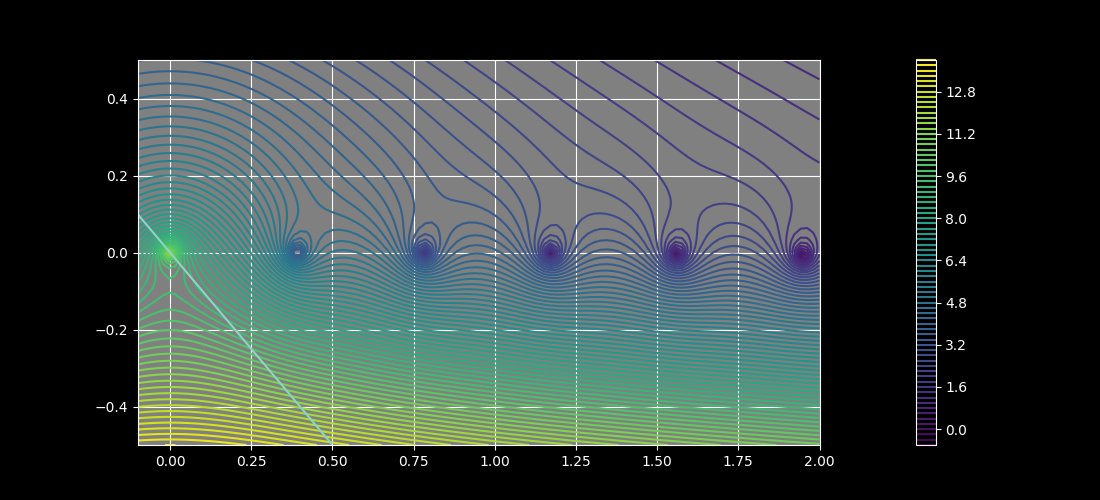

In [17]:
A.deteriminant_plot(-.1, 2, -.5, .5, mode_type='guided')

In [6]:
z_guesses = np.array([.4, 1.1, 1.9, 
                      # 2.8, 3.5, 4.2,
                     #  -4.98+.125j, -5.6+.25j, -6.15+.2j, -6.8 + 1.2j,
                     # -7.5 + .1j, -8.25+.85j, -9 + .1j, -9.75 + .13j,
                     ])
Zs = []
for z in z_guesses:
    Zs.append(newton(A.determinant_Z, z, args=('TE', 'guided')))
Zs = np.array(Zs)

for Z in Zs:
    plt.plot(Z.real, Z.imag, marker='o')

In [24]:
P_leaky = []

Propagator_Class = A.propagator()

for Z in Zs:
    PZe = Propagator_Class(A.circular_contour(Z, 1e-6, 15, orientation='cw'), f0=f0, Lx=-b, Rx=b)
    P_leaky.append(PZe)

In [39]:
F_leaky = []

for Z in Zs:
    F_leaky.append(A.fields_Z(Z, mode_type='guided', rounding=10))

In [25]:
full_leaky = lambda x : sum([P.slice_propagate(x) for P in P_leaky])
Full_leaky = lambda x, z : sum([P.propagate(x, zs=z) for P in P_leaky])


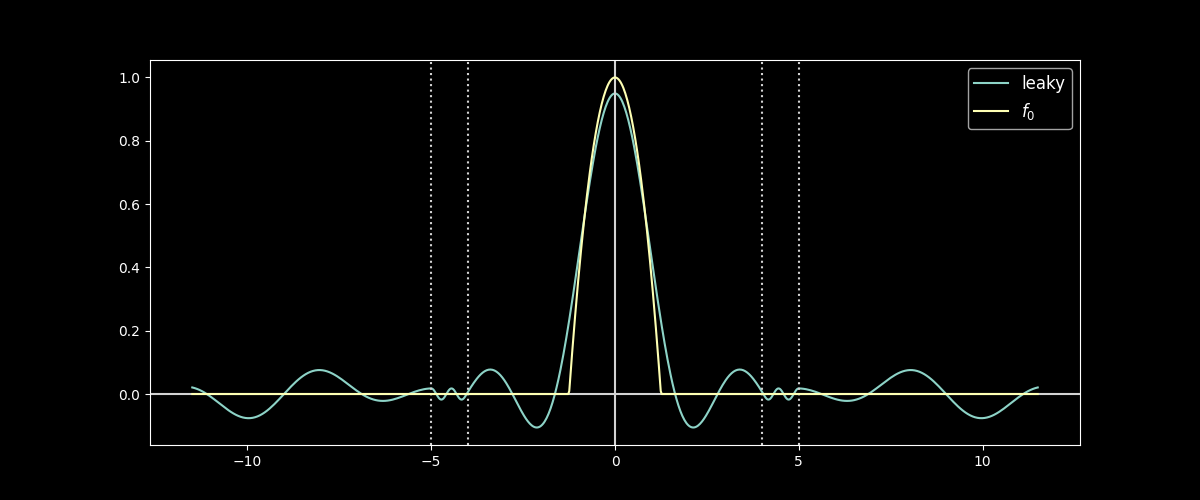

In [26]:
A.plot_field_1d(full_leaky, label='leaky')
A.add_1d_plot(f0, label='$f_0$')

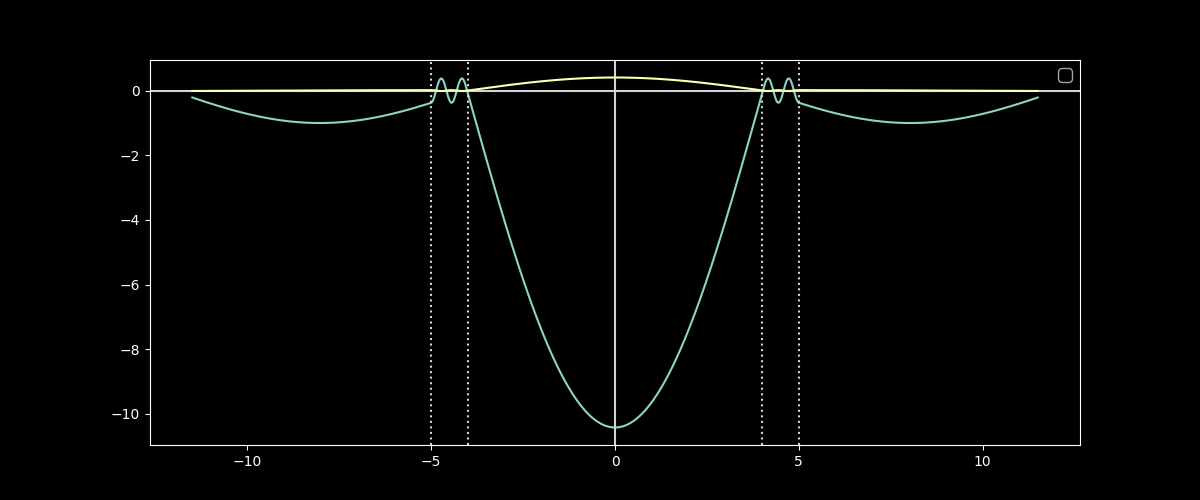

In [113]:
j = 0
A.plot_field_1d(F_leaky[j] )
A.add_1d_plot(P_leaky[j].slice_propagate)

In [114]:
j = 0
x = 3
ratio = F_leaky[j](x) / P_leaky[j].propagate(x,zs=0)
ratio

array([[-25.82433688+64.5401001j]])

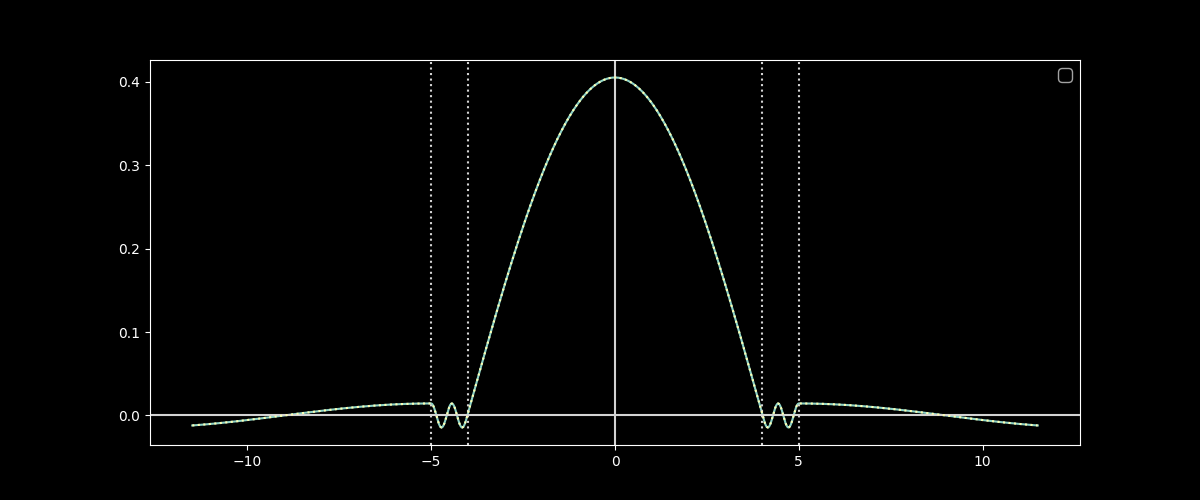

In [115]:
A.plot_field_1d(lambda x: 1/ratio[0] * F_leaky[j](x) )
A.add_1d_plot(P_leaky[j].slice_propagate, linestyle=':')


In [111]:
j = 0
x = 3
ratio = F_leaky[j](x) / P_leaky[j].propagate(x,zs=0)

cf1 = quad(lambda x: F_leaky[j](x)**2, -b, b, complex_func=True)[0]
cf2 = quad(lambda x: F_leaky[j](x)*f0(x), -b, b, complex_func=True)[0]
cf1, cf2, ratio/cf1, ratio/cf2

((119.80573674940982+0j),
 (-11.397828464465839-5.436463639230453j),
 array([[-0.21537898+0.10201713j]]),
 array([[1.42764111-1.75327748j]]))

The ratio between the leaky modes we construct and the correct ones does not appear to depend directly on the integrals of the leaky modes themselves or with the input function f0